In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd /content/drive/My Drive/kalapa

/content/drive/My Drive/kalapa


In [ ]:
!pip install feature_engine
!pip install unidecode
!pip install category_encoders

In [ ]:
from itertools import combinations

import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from itertools import combinations

import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import re
import warnings

import lightgbm as lgb
from unidecode import unidecode
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

from feature_engine import categorical_encoders as ce

from itertools import combinations
from datetime import datetime
from contextlib import contextmanager

In [ ]:
DROP = ["gioiTinh","info_social_sex", 'currentLocationCity', 'currentLocationName', 'homeTownCity', 'homeTownName'] + [f"Field_{c}" for c in [11, 14, 15, 16, 17, 18, 24,25, 26, 30, 31, 32, 33, 34,35, 37,40,45, 46, 48,49, 52, 56, 57, 68]]
DATE = ["Field_{}".format(i) for i in [5, 6, 7, 8, 9, 11, 15, 25, 32, 33, 34, 35, 40]]
DATETIME = ["Field_{}".format(i) for i in [1, 2, 43, 44]]

In [ ]:
@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

def Gini(y_true, y_pred):
    # check and get number of samples
    assert y_true.shape == y_pred.shape
    n_samples = y_true.shape[0]

    # sort rows on prediction column
    # (from largest to smallest)
    arr = np.array([y_true, y_pred]).transpose()
    true_order = arr[arr[:, 0].argsort()][::-1, 0]
    pred_order = arr[arr[:, 1].argsort()][::-1, 0]

    # get Lorenz curves
    L_true = np.cumsum(true_order) * 1. / np.sum(true_order)
    L_pred = np.cumsum(pred_order) * 1. / np.sum(pred_order)
    L_ones = np.linspace(1 / n_samples, 1, n_samples)

    # get Gini coefficients (area between curves)
    G_true = np.sum(L_ones - L_true)
    G_pred = np.sum(L_ones - L_pred)

    # normalize to true Gini coefficient
    return G_pred * 1. / G_true

def lgb_gini(y_pred, dataset_true):
    y_true = dataset_true.get_label()
    return 'gini', Gini(y_true, y_pred), True

In [ ]:
def subtract_date(date1,date2, df):
    df[date1] = pd.to_datetime(df[date1], infer_datetime_format=True)
    df[date2] = pd.to_datetime(df[date2], infer_datetime_format=True)
    df[date1+date2] = (df[date2] - df[date1]).dt.days
    
def process_ngaySinh(s):
    if s != s:
        return np.nan
    try:
        s = int(s)
    except ValueError:
        s = s.split(" ")[0]
        
    return datetime.strptime(str(s)[:6], "%Y%m")

def datetime_normalize(s):
    if s != s:
        return np.nan
    
    s = s.split(".")[0]
    if s[-1] == "Z":
        s = s[:-1]
        
    date, time = s.split("T")
    datetime_obj = datetime.strptime(s, "%Y-%m-%dT%H:%M:%S")
    return datetime_obj

def date_normalize(s):
    if s != s:
        return np.nan
    
    try:
        datetime_obj = datetime.strptime(s, "%m/%d/%Y")
    except:
        datetime_obj = datetime.strptime(s, "%Y-%m-%d")
        
    return datetime_obj
  
def process_datetime_cols(df):
    cat_cols = []
    for col in DATETIME:
        df[col] = df[col].apply(datetime_normalize)
        
    for col in DATE:
        if col == "Field_34":
            continue
        df[col] = df[col].apply(date_normalize)

    df["Field_34"] = df["Field_34"].apply(process_ngaySinh)
    df["ngaySinh"] = df["ngaySinh"].apply(process_ngaySinh)
    
    cat_cols += DATE + DATETIME
    for col in DATE + DATETIME:
        df[col] = df[col].dt.strftime('%d-%m-%Y')
    
    subtract_date('Field_5','Field_6',df)
    subtrac_List = ['Field_1', 'Field_2', 'Field_43', 'Field_44', 'Field_7','Field_8', 'Field_9']
    subtract_2C = list(combinations(subtrac_List, 2))
    for l in subtract_2C:
        subtract_date(l[0],l[1],df)
      
    for cat in ['F', 'E', 'C', 'G', 'A']:
        subtract_date(f'{cat}_startDate', f'{cat}_endDate', df)
    print(df.shape) 
    return df
  
def str_normalize(s):
    s = str(s).strip().lower()
    s = re.sub(' +', " ", s)
    return s

def process_location(df):
    for col in ["currentLocationLocationId", "homeTownLocationId", "currentLocationLatitude", "currentLocationLongitude", 
                   "homeTownLatitude", "homeTownLongitude"]:
        df[col].replace(0, np.nan, inplace=True)

#     df["currentLocationLocationId"] = df["currentLocationLocationId"].apply(str_normalize).astype("category")
#     df["homeTownLocationId"] = df["homeTownLocationId"].apply(str_normalize).astype("category")

    return df

    
def combine_gender(s):
    x, y = s
    return x if x != None else y if y != None else None

def process_gender(df):
    df["gender"] = df[["gioiTinh", "info_social_sex"]].apply(combine_gender, axis=1).astype("category")
    return df

def process_ordinal(df):        
    df["subscriberCount"].replace(0, np.nan, inplace=True)
    df["friendCount"].replace(0, np.nan, inplace=True)
    
    df["Field_13"] = df["Field_13"].apply(lambda x: 1 if x == x else 0)
    df["Field_38"] = df["Field_38"].map({0: 0.0, 1: 1.0, "DN": np.nan, "TN": np.nan, "GD": np.nan})
    df["Field_62"] = df["Field_62"].map({"I": 1, "II": 2, "III": 3, "IV": 4, "V": 5, "Ngoài quốc doanh Quận 7": np.nan})
    df["Field_47"] = df["Field_47"].map({"Zezo": 0, "One": 1, "Two": 2, "Three": 3, "Four": 4})
    
    df["Field_27"] = df["Field_27"].replace({0.0: np.nan})
    df["Field_28"] = df["Field_28"].replace({0.0: np.nan})
        
    for col in df.columns:
        if df[col].dtype.name == "object":
            df[col] = df[col].apply(str_normalize).astype("category")
            
    return df

def transform(df):
    df = process_datetime_cols(df)
    df = process_gender(df)
    df = process_location(df)
    df = process_ordinal(df)
    df["null_sum"] = df.isnull().sum(axis=1)
    return df.drop(DROP, 1)

In [ ]:
df_train = pd.read_csv('/content/drive/My Drive/kalapa/dataset/train.csv')
df_test = pd.read_csv('/content/drive/My Drive/kalapa/dataset/test.csv')
#df_a = pd.read_csv('/content/drive/My Drive/kalapa/dataset/train.csv')
df_all = df_train.drop(['label'], 1).append(df_test)
    
with timer("Preprocess"):
    df_all_fe = transform(df_all.copy())
    df_all_fe.replace(np.nan, 0)
    print("Bureau df shape:", df_all_fe.shape)
    df_all_fe['Age'] = df_all_fe.ngaySinh.apply(lambda x: 2020 - x.year)
    df_all_fe = df_all_fe.drop('ngaySinh', axis = 1)
    cols_select = [x for x in df_all_fe.columns if x not in DATE + DATETIME  + [f'{cat}_endDate' for cat in ['F', 'E', 'C', 'G', 'A']] + [f'{cat}_startDate' for cat in ['F', 'E', 'C', 'G', 'A']]]
    df_fe = df_all_fe[cols_select]
    df_fe.replace([np.inf, -np.inf], -99999, inplace=True)

    y_label = df_train["label"]
    train_fe = df_fe[df_fe["id"] < df_train.shape[0]]
    test_fe = df_fe[df_fe["id"] >= df_train.shape[0]]

    # Label-Encoding
    lbl = LabelEncoder()
    for col in df_fe.columns:
      if df_fe[col].dtype.name == "category":
        train_fe[col] = train_fe[col].astype(str)
        test_fe[col] = test_fe[col].astype(str)
        encoder = ce.CountFrequencyCategoricalEncoder(encoding_method='frequency')
        train_fe[col] = train_fe[col].fillna('None')
        test_fe[col] = test_fe[col].fillna('None')

        # Only take the common values in Train/Test set
        common_vals = list(set(train_fe[col]).intersection(set(test_fe[col])))

        # Take if vals appeared both 5 times
        common_vals = set(train_fe[col].value_counts()[train_fe[col].value_counts() > 4].index).intersection(test_fe[col].value_counts()[test_fe[col].value_counts()>4].index)

        # Replace not-common values with "Missing" or np.nan
        train_fe.loc[~train_fe[col].isin(common_vals), col] = 'Missing'
        test_fe.loc[~test_fe[col].isin(common_vals), col] = 'Missing'

        # Implement LE
        lbl.fit(train_fe[col].tolist() + test_fe[col].tolist())
        train_fe[col] = lbl.transform(train_fe[col])
        test_fe[col] = lbl.transform(test_fe[col])

    print(train_fe.shape)
    print(test_fe.shape)


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (35,43) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (34,42) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(73411, 221)
Bureau df shape: (73411, 192)


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4172: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

(53030, 173)
(20381, 173)
Preprocess - done in 18s


In [ ]:
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100)
X_train = train_fe.replace(np.nan, 0)
y_train = y_label
#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [ ]:
feature_imp = pd.Series(clf.feature_importances_,index=train_fe.columns).sort_values(ascending=False)

In [ ]:
#feature_imp = feature_imp20.head(20)
#print(feature_imp)
#feature_imp = pd.Series(feature_imp, index = feature_imp.columns)
feature_imp[(20,30)]

SyntaxError: ignored

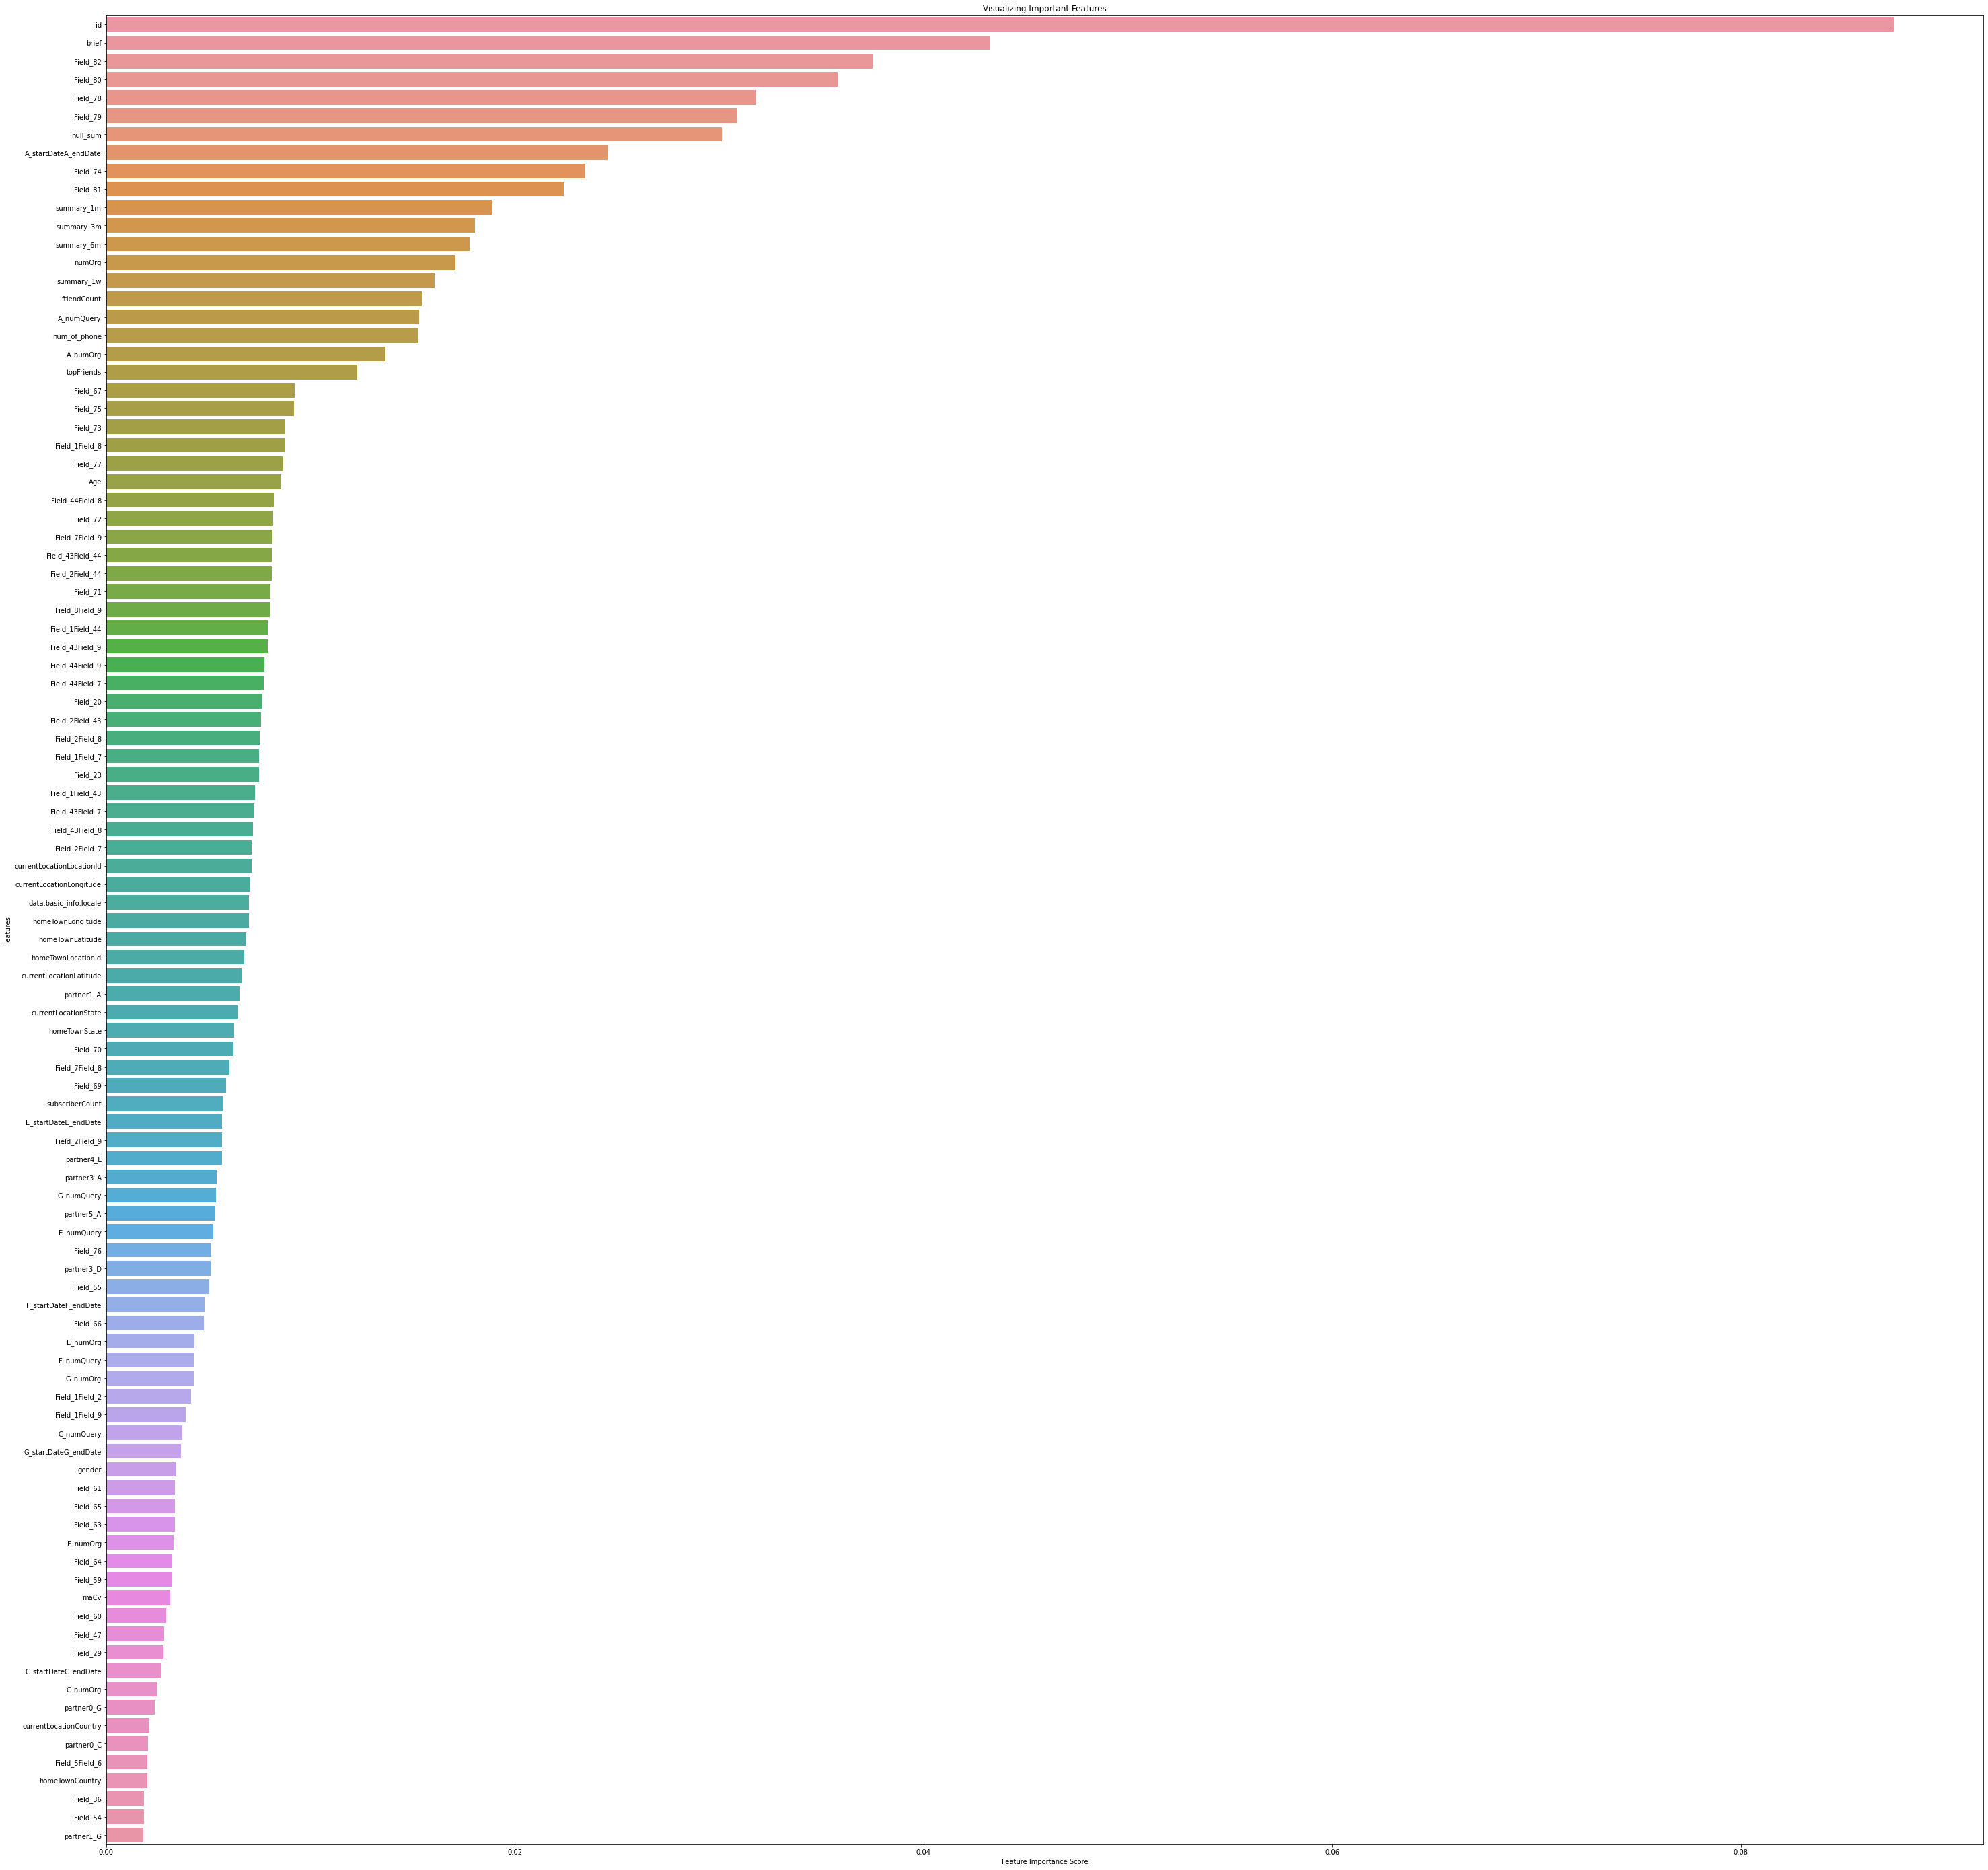

In [ ]:
import seaborn as sns
%matplotlib inline
# Creating a bar plot
plt.figure(figsize = (50, 50))
sns.barplot(x=feature_imp.head(100), y=feature_imp.head(100).index)

# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
#plt.legend()
plt.show()